In [ ]:
import pandas as pd

# Specify the path to your CSV file
csv_file_path = '/Users/carlogress/Documents/GitHub/TaD-final-assignment/speeches.csv'

# Read the CSV file into a DataFrame
all_speeches_df = pd.read_csv(csv_file_path)

# Display the DataFrame
print(all_speeches_df)


In [ ]:
import torch
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the pre-trained model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("manifesto-project/manifestoberta-xlm-roberta-56policy-topics-sentence-2023-1-1")
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")

# Function to classify each speech and return category and value
def classify_speech(speech):
    inputs = tokenizer(speech,
                       return_tensors="pt",
                       max_length=200,
                       padding="max_length",
                       truncation=True
                       )
    
    logits = model(**inputs).logits
    probabilities = torch.softmax(logits, dim=1).tolist()[0]
    probabilities = {model.config.id2label[index]: round(probability * 100, 2) for index, probability in enumerate(probabilities)}
    probabilities = dict(sorted(probabilities.items(), key=lambda item: item[1], reverse=True))
    
    predicted_category = model.config.id2label[logits.argmax().item()]
    predicted_value = probabilities[predicted_category]

    return predicted_category, predicted_value

# Apply the classification function to the 'speech' column and create new 'category' and 'value' columns
all_speeches[['category', 'value']] = all_speeches['speech'].apply(classify_speech).apply(pd.Series)

# Convert the 'year' column to numeric
all_speeches['year'] = pd.to_numeric(all_speeches['year'], errors='coerce')

# Group by 'year' and print the first row for each group
first_row_per_year = all_speeches.groupby('year').first()[['name', 'category', 'value']]

# Display the result with a more readable format
print(first_row_per_year.to_string())



In [ ]:
import matplotlib.pyplot as plt
# Filter the DataFrame to include only the desired category
env_protection_df = all_speeches[all_speeches['category'] == '501 - Environmental Protection: Positive']

# Group by 'year' and find the count of occurrences with the highest value per year
count_per_year = env_protection_df.groupby('year')['value'].idxmax().reset_index().groupby('year').count()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(count_per_year.index, count_per_year['value'], marker='o')
plt.title('Count of Category 501 - Environmental Protection: Positive with Highest Value per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the pre-trained model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("manifesto-project/manifestoberta-xlm-roberta-56policy-topics-sentence-2023-1-1")
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")

# Assuming your DataFrame is named 'all_speeches' and the column containing speech information is named 'speech'
# Replace 'all_speeches' and 'speech' with your actual DataFrame and column names
all_speeches = pd.read_csv('/Users/carlogress/Documents/GitHub/TaD-final-assignment/speeches.csv')  # replace with the actual path

def classify_speech(speech):
    inputs = tokenizer(speech,
                       return_tensors="pt",
                       max_length=200,
                       padding="max_length",
                       truncation=True
                       )
    
    logits = model(**inputs).logits
    probabilities = torch.softmax(logits, dim=1).tolist()[0]
    predicted_category = model.config.id2label[logits.argmax().item()]

    return predicted_category

# Apply the classification function to the 'speech' column and create a new 'category' column
all_speeches['category'] = all_speeches['speech'].apply(classify_speech)

# Convert the 'year' column to numeric
all_speeches['year'] = pd.to_numeric(all_speeches['year'], errors='coerce')

# Group by 'year' and find the most assigned category per year
most_assigned_per_year = all_speeches.groupby(['year', 'category']).size().reset_index(name='count')
idx = most_assigned_per_year.groupby(['year'])['count'].transform(max) == most_assigned_per_year['count']
most_assigned_per_year = most_assigned_per_year[idx]

# Plot the data as a bar plot
plt.figure(figsize=(14, 8))
for category in most_assigned_per_year['category'].unique():
    category_data = most_assigned_per_year[most_assigned_per_year['category'] == category]
    plt.bar(category_data['year'], category_data['count'], label=category)

plt.title('Most Assigned Category per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Category')
plt.grid(True)

# Save the plot as an image
plt.savefig('berta_top_category.png')

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the pre-trained model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("manifesto-project/manifestoberta-xlm-roberta-56policy-topics-sentence-2023-1-1")
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")

# Assuming your DataFrame is named 'all_speeches' and the column containing speech information is named 'speech'
# Replace 'all_speeches' and 'speech' with your actual DataFrame and column names
all_speeches = pd.read_csv('speeches.csv')  # replace with the actual path

# Function to classify each speech and return the top category
def classify_top_category(speech):
    inputs = tokenizer(speech,
                       return_tensors="pt",
                       max_length=200,
                       padding="max_length",
                       truncation=True
                       )
    
    logits = model(**inputs).logits
    predicted_category = model.config.id2label[logits.argmax().item()]

    return predicted_category

# Apply the classification function to get the top category for each speech
all_speeches['top_category'] = all_speeches['speech'].apply(classify_top_category)

# Convert the 'year' column to numeric
all_speeches['year'] = pd.to_numeric(all_speeches['year'], errors='coerce')

# Group by 'year' to count total speeches and the top category
speech_counts = all_speeches.groupby(['year', 'top_category']).size().reset_index(name='count')

# Calculate the share of the top category for each year
speech_counts['share'] = speech_counts.groupby('year')['count'].transform(lambda x: x / x.sum())

# Set up colors and labels for each category
colors = plt.cm.tab10(range(len(speech_counts['top_category'].unique())))
category_colors = dict(zip(speech_counts['top_category'].unique(), colors))

# Plot the data
plt.figure(figsize=(14, 8))
for category, color in category_colors.items():
    category_data = speech_counts[speech_counts['top_category'] == category]
    plt.bar(category_data['year'], category_data['share'], color=color, label=category)

plt.title('Share of Top Category for Each Year')
plt.xlabel('Year')
plt.ylabel('Share of Speeches in Category')
plt.legend(title='Top Category')
plt.grid(True)

# Save the plot as an image
plt.savefig('share_of_top_category_per_year.png')
plt.show()


In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the pre-trained model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("manifesto-project/manifestoberta-xlm-roberta-56policy-topics-sentence-2023-1-1")
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")

# Assuming your DataFrame is named 'all_speeches' and the column containing speech information is named 'speech'
# Replace 'all_speeches' and 'speech' with your actual DataFrame and column names
all_speeches = pd.read_csv('speeches.csv')  # replace with the actual path

# Function to classify each speech and return the top category
def classify_top_category(speech):
    inputs = tokenizer(speech,
                       return_tensors="pt",
                       max_length=200,
                       padding="max_length",
                       truncation=True
                       )
    
    logits = model(**inputs).logits
    predicted_category = model.config.id2label[logits.argmax().item()]

    return predicted_category

In [24]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the pre-trained model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("manifesto-project/manifestoberta-xlm-roberta-56policy-topics-sentence-2023-1-1")
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")

# Assuming your DataFrame is named 'all_speeches' and the column containing speech information is named 'speech'
# Replace 'all_speeches' and 'speech' with your actual DataFrame and column names
all_speeches = pd.read_csv('speeches.csv')  # replace with the actual path

# Function to classify each speech and return the top three categories and values
def classify_top_three_categories_and_values(speech):
    inputs = tokenizer(speech,
                       return_tensors="pt",
                       max_length=200,
                       padding="max_length",
                       truncation=True
                       )

    logits = model(**inputs).logits
    probabilities = torch.softmax(logits, dim=1).tolist()[0]
    top_category_indices = sorted(range(len(probabilities)), key=lambda i: probabilities[i], reverse=True)[:3]
    top_categories = [model.config.id2label[index] for index in top_category_indices]
    top_category_values = [probabilities[index] for index in top_category_indices]

    return top_categories[0], top_category_values[0], top_categories[1], top_category_values[1], top_categories[2], top_category_values[2]

# Apply the classification function to get the top three categories and values for each speech
all_speeches[['top_category', 'top_value', 'second_category', 'second_value', 'third_category', 'third_value']] = all_speeches['speech'].apply(classify_top_three_categories_and_values).apply(pd.Series)

# Convert the 'year' column to numeric
all_speeches['year'] = pd.to_numeric(all_speeches['year'], errors='coerce')

# Print the DataFrame to verify the new columns
print(all_speeches)


     year                                             header  \
0    2023                  Remarks by OPEC Secretary General   
1    2023                  Address by OPEC Secretary General   
2    2023                  Address by OPEC Secretary General   
3    2022  OPEC Statement to the UN Climate Change Confer...   
4    2022          Keynote address by OPEC Secretary General   
..    ...                                                ...   
332  2003       Challenges to OPEC in the Medium & Long Term   
333  2003  Cooperation between producers & consumers: an ...   
334  2003  Short- and long-term oil price trends in the a...   
335  2003  Statement by OPEC Secretary General to the Ara...   
336  2003               The Role of OPEC in the 21st Century   

                                           information  \
0    Delivered by HE Haitham Al Ghais, OPEC Secreta...   
1    Delivered by HE Haitham Al Ghais, OPEC Secreta...   
2    Delivered by HE Haitham Al Ghais, OPEC Secreta...   

                                 top_category  top_value                               second_category  second_value                                third_category  third_value
             107 - Internationalism: Positive   0.644729 101 - Foreign Special Relationships: Positive      0.156107                 407 - Protectionism: Negative     0.043150
             107 - Internationalism: Positive   0.495198                 407 - Protectionism: Negative      0.168232 101 - Foreign Special Relationships: Positive     0.092291
             107 - Internationalism: Positive   0.820047 101 - Foreign Special Relationships: Positive      0.048846           416 - Anti-Growth Economy: Positive     0.032194
             107 - Internationalism: Positive   0.866897      501 - Environmental Protection: Positive      0.044760 101 - Foreign Special Relationships: Positive     0.023445
             107 - Internationalism: Positive   0.204616                     305 - Political Authority      0.184201    

In [45]:
category_counts = all_speeches.groupby('year')[['top_category', 'top_value', 'second_category', 'second_value', 'third_category', 'third_value']].agg(lambda x: x.value_counts().idxmax())

# Print the data for each year
for year, data in category_counts.iterrows():
    print(f'\nYear: {year}\n')
    print(f"1. {data['top_category']} ({data['top_value']:.2f})")
    print(f"2. {data['second_category']} ({data['second_value']:.2f})")
    print(f"3. {data['third_category']} ({data['third_value']:.2f})\n")


Year: 2003

1. 107 - Internationalism: Positive (0.15)
2. 407 - Protectionism: Negative (0.13)
3. 408 - Economic Goals (0.13)


Year: 2004

1. 410 - Economic Growth: Positive (0.61)
2. 408 - Economic Goals (0.25)
3. 411 - Technology and Infrastructure (0.03)


Year: 2005

1. 107 - Internationalism: Positive (0.41)
2. 101 - Foreign Special Relationships: Positive (0.36)
3. 407 - Protectionism: Negative (0.09)


Year: 2006

1. 107 - Internationalism: Positive (0.57)
2. 408 - Economic Goals (0.21)
3. 407 - Protectionism: Negative (0.12)


Year: 2007

1. 107 - Internationalism: Positive (0.48)
2. 305 - Political Authority (0.14)
3. 410 - Economic Growth: Positive (0.05)


Year: 2008

1. 107 - Internationalism: Positive (0.20)
2. 410 - Economic Growth: Positive (0.14)
3. 101 - Foreign Special Relationships: Positive (0.09)


Year: 2009

1. 107 - Internationalism: Positive (0.37)
2. 408 - Economic Goals (0.16)
3. 408 - Economic Goals (0.13)


Year: 2010

1. 107 - Internationalism: Positive 

In [49]:
import pandas as pd

# Assuming the DataFrame is named 'all_speeches'
# If your DataFrame has a different name, replace 'all_speeches' with your actual DataFrame name
# Also, replace the column names if they are different in your DataFrame

# Create a list to store the results
result_data = []

# Iterate through each year
for year in all_speeches['year'].unique():
    # Filter the DataFrame for the current year
    year_data = all_speeches[all_speeches['year'] == year]
    
    # Count the occurrences of each category in 'top_category', 'second_category', and 'third_category'
    top_category_count = year_data['top_category'].value_counts().iloc[0]
    second_category_count = year_data['second_category'].value_counts().iloc[0]
    third_category_count = year_data['third_category'].value_counts().iloc[0]
    
    # Find the most frequently occurring category in 'top_category', 'second_category', and 'third_category'
    top_category = year_data['top_category'].mode().iloc[0]
    second_category = year_data['second_category'].mode().iloc[0]
    third_category = year_data['third_category'].mode().iloc[0]
    
    # Append the results to the list
    result_data.append({
        'Year': year,
        'Top Category': f'{top_category} ({top_category_count})',
        'Second Category': f'{second_category} ({second_category_count})',
        'Third Category': f'{third_category} ({third_category_count})'
    })

# Create a DataFrame from the list
result_df = pd.DataFrame(result_data)

# Print the result DataFrame
print(result_df)



    Year                           Top Category  \
0   2023   107 - Internationalism: Positive (3)   
1   2022   107 - Internationalism: Positive (5)   
2   2021  107 - Internationalism: Positive (12)   
3   2020  107 - Internationalism: Positive (26)   
4   2019  107 - Internationalism: Positive (25)   
5   2018  107 - Internationalism: Positive (23)   
6   2017  107 - Internationalism: Positive (28)   
7   2016  107 - Internationalism: Positive (11)   
8   2015   107 - Internationalism: Positive (5)   
9   2014   107 - Internationalism: Positive (2)   
10  2013   107 - Internationalism: Positive (5)   
11  2012   107 - Internationalism: Positive (6)   
12  2011   107 - Internationalism: Positive (6)   
13  2010   107 - Internationalism: Positive (5)   
14  2009   107 - Internationalism: Positive (3)   
15  2008   107 - Internationalism: Positive (5)   
16  2007   107 - Internationalism: Positive (6)   
17  2006  107 - Internationalism: Positive (18)   
18  2005  107 - Internationalis

# Nmber of speeches plt 

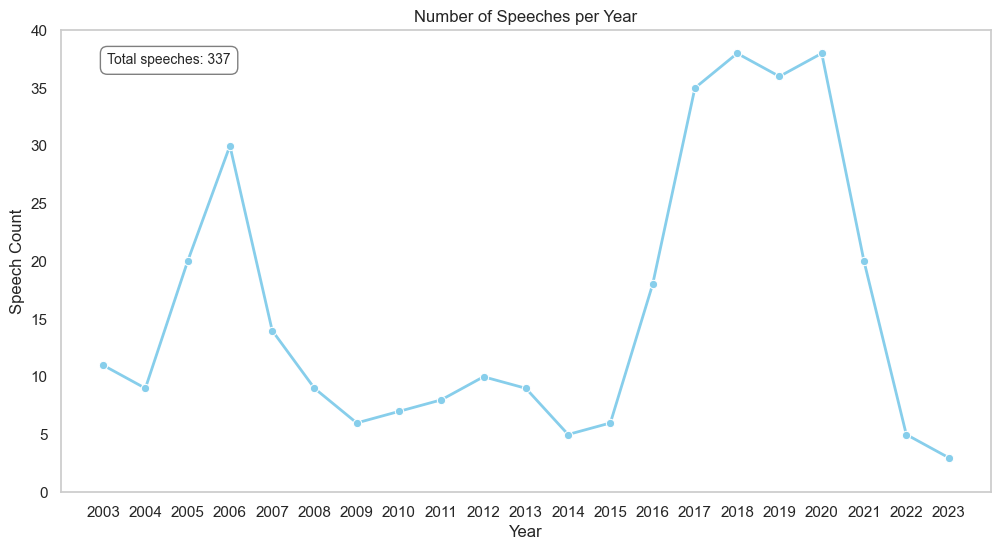

In [61]:
import seaborn as sns

# Assuming your DataFrame is named 'all_speeches' and the column containing speech information is named 'speech'
# Replace 'all_speeches' and 'speech' with your actual DataFrame and column names

# Convert the 'year' column to numeric
all_speeches['year'] = pd.to_numeric(all_speeches['year'], errors='coerce')

# Group by 'year' and count the number of speeches per year
speech_count_per_year = all_speeches.groupby('year').size().reset_index(name='count')

# Set Seaborn style
sns.set(style="whitegrid")

# Plot the data using Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=speech_count_per_year, x='year', y='count', marker='o', color='skyblue', linewidth=2)
plt.title('Number of Speeches per Year')
plt.xlabel('Year')
plt.ylabel('Speech Count')
plt.xticks(speech_count_per_year['year'].astype(int))  # Display every year as integers on the x-axis
plt.ylim(0, 40)  # Set the y-axis range to 40

# Add a text box displaying the total number of speeches in the top-left corner with a frame
total_speeches = all_speeches.shape[0]
plt.text(0.05, 0.95, f'Total speeches: {total_speeches}', transform=plt.gca().transAxes,
         fontsize=10, ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))
plt.grid(False)
plt.savefig("number_of_speeches.png")
plt.show()
